### Evaluation of Manipulation experiments

In [4]:
import os
import re
import numpy as np
import signal_logger
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib

import ipywidgets as widgets 
from IPython.display import display

import rospkg
from utilities import *

%matplotlib notebook

In [5]:
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['legend.title_fontsize'] = 15

rospack = rospkg.RosPack()
PLOT_EXPERIMENT = True
COMPARE_METHODS = False
FORMAT_PLOT = False
ROOT_DIR = "/media/giuseppe/My Passport/Work/logs_mppi/passivity_tests/"
#ROOT_DIR = os.path.join(rospack.get_path("mppi_manipulation_royalpanda"), "logs", "rates_test")
LOG_PREFIX = ""
LOG_FILE = os.path.join(ROOT_DIR, "filter.silo")
LOG_FILES = get_files(ROOT_DIR, LOG_PREFIX)
REQUIRED_FIELDS = [
    "log/sim_time", 
    "log/solver/rate",
    "log/solver/delay_steps",
    "log/solver/rollouts/min_cost",
    
    "log/opt_time",
    "log/simulation_step",
    "log/power_from_interaction",
    "log/stage_cost", 
    "log/torque_command",
    
    "log/external_torque",
    "log/ground_truth_external_torque",
    "log/external_wrench",
    "log/external_wrench_filtered",
    "log/position_desired",
    "log/position_measured",
    
    "log/velocity_command",
    "log/velocity_measured",
    "log/velocity_mppi",
    
    "log/cartesian_limits_violation", 
    "log/joint_limits_violation",
    "log/tank_state", 
    "log/power_channels",
    "log/state"
]
LOG_FILES_PRINT = '\n'.join(LOG_FILES)
print(f"""
>> Root dir: 
{ROOT_DIR}
>> Prefix: 
{LOG_PREFIX}
>> Log files: 
{LOG_FILES_PRINT}
""")


>> Root dir: 
/media/giuseppe/My Passport/Work/logs_mppi/passivity_tests/
>> Prefix: 

>> Log files: 
/media/giuseppe/My Passport/Work/logs_mppi/passivity_tests/h_new_shelf_filter_in_out.silo
/media/giuseppe/My Passport/Work/logs_mppi/passivity_tests/a_new_shelf.silo
/media/giuseppe/My Passport/Work/logs_mppi/passivity_tests/a_new_shelf_filter_in_out.silo
/media/giuseppe/My Passport/Work/logs_mppi/passivity_tests/b_new_shelf.silo
/media/giuseppe/My Passport/Work/logs_mppi/passivity_tests/b_new_shelf_filter_in_out.silo
/media/giuseppe/My Passport/Work/logs_mppi/passivity_tests/c_new_shelf.silo
/media/giuseppe/My Passport/Work/logs_mppi/passivity_tests/c_new_shelf_filter_in_out.silo
/media/giuseppe/My Passport/Work/logs_mppi/passivity_tests/d_new_shelf.silo
/media/giuseppe/My Passport/Work/logs_mppi/passivity_tests/d_new_shelf_filter_in_out.silo
/media/giuseppe/My Passport/Work/logs_mppi/passivity_tests/e_new_shelf.silo
/media/giuseppe/My Passport/Work/logs_mppi/passivity_tests/e_new_sh

### Fields available in log fie

In [6]:
silo = signal_logger.Silo(LOG_FILES[0])
#print_keys(silo)

Removing prefix /log/ which is common to all signals


### Some utilities
Use the naming convention to determine if the experiment was run with or without the filter and which object we try to manipulate

In [7]:
class ExperimentType:
    NO_FILTER = "no_filter"
    FILTER_OUT = "filter_out"
    FILTER_IN = "filter_in"
    FILTER_IN_OUT = "filter_in_out"
    
    @classmethod
    def get_labels(cls):
        return ["NO_FILTER", "FILTER_OUT", "FILTER_IN", "FILTER_IN_OUT"]
    
def experiment_type_from_name(name):
    if "filter_in_out" in name:
        return ExperimentType.FILTER_IN_OUT
    elif "filter_in" in name:
        return ExperimentType.FILTER_IN 
    elif "filter_out" in name:
        return ExperimentType.FILTER_OUT
    else:
        return ExperimentType.NO_FILTER

def get_rollouts_from_name(name):
    return re.sub("[^0-9]", "", name)

def get_object_from_name(name):
    object_types = ['shelf', 'door', 'microwave', 'drawer', 'valve', 'new_shelf']
    for object_type in object_types:
        if object_type in name:
            return object_type
    return 'none'

def set_facetgrid_style(g, legend=False, title=True):
    for i, (col_val, ax) in enumerate(g.axes_dict.items()):
        ax.set_title(col_val if title else "", fontsize=60)
        ax.yaxis.label.set_size(50)
        ax.tick_params(axis='y', which='major', labelsize=40)
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        if i == len(g.axes_dict.items())-1 and legend:
            ax.legend(fontsize=48)
        g.fig.set_size_inches(42.5, 12.5)

### Collect and process
Each experiment contributes to a single dictionary where all the information is stored

In [8]:
final_time = 90.0
data = {}
data['experiment_name'] = []
data['joint_limits_violation_se'] = []
data['cartesian_limits_violation_se'] = []
data['average_wrench_norm'] = []
data['experiment_type'] = []
data['power_cost'] = []
data['object_type'] = []
data['x'] = []
data['average_stage_cost'] = []
data['wrench_norm'] = []
data['rollouts'] = []
data['dissipated_power'] = []

for experiment_idx, file in enumerate(LOG_FILES):
    print(f"{experiment_idx} processed out of {len(LOG_FILES)}")
    experiment_name = file.split('/')[-1].replace('.silo', '')
    silo = signal_logger.Silo(file)
    silo_dict = to_dictionary(silo, REQUIRED_FIELDS)

    for key, value in silo_dict.items():
        if experiment_idx == 0:
            data[key] = [value]
        else:
            data[key].append(value)
    
    time = silo_dict['sim_time']
    
    joint_violation_se = matrix_to_se(time, 0.0, final_time, silo_dict['joint_limits_violation'])
    carts_violation_se = matrix_to_se(time, 0.0, final_time, silo_dict['cartesian_limits_violation'])
    average_wrench = average_col_norm(time, 0.0, final_time, silo_dict['external_wrench_filtered'], 
                                     threshold = 0.0)
    
    wrench_norm = col_norm(time, 0.0, final_time, silo_dict['external_wrench_filtered'])
    average_stage_cost = np.mean(silo_dict['stage_cost'])
    
    data['experiment_name'].append(experiment_name)
    data['joint_limits_violation_se'].append(joint_violation_se)
    data['cartesian_limits_violation_se'].append(carts_violation_se)
    data['average_wrench_norm'].append(average_wrench)
    data['experiment_type'].append(experiment_type_from_name(experiment_name))
    data['power_cost'].append("power" in experiment_name)
    data['object_type'].append(get_object_from_name(experiment_name))
    data['x'].append('data')
    data['average_stage_cost'].append(average_stage_cost)
    data['wrench_norm'].append(wrench_norm)
    data['rollouts'].append(get_rollouts_from_name(experiment_name))
    data['dissipated_power'].append(np.sum(data['power_from_interaction'][-1]))
    
data = pd.DataFrame.from_dict(data)

0 processed out of 40
Removing prefix /log/ which is common to all signals
1 processed out of 40
Removing prefix /log/ which is common to all signals
2 processed out of 40
Removing prefix /log/ which is common to all signals
3 processed out of 40
Removing prefix /log/ which is common to all signals
4 processed out of 40
Removing prefix /log/ which is common to all signals
5 processed out of 40
Removing prefix /log/ which is common to all signals
6 processed out of 40
Removing prefix /log/ which is common to all signals
7 processed out of 40
Removing prefix /log/ which is common to all signals
8 processed out of 40
Removing prefix /log/ which is common to all signals
9 processed out of 40
Removing prefix /log/ which is common to all signals
10 processed out of 40
Removing prefix /log/ which is common to all signals
11 processed out of 40
Removing prefix /log/ which is common to all signals
12 processed out of 40
Removing prefix /log/ which is common to all signals
13 processed out of 40

### Select experiment to plot

In [9]:
exp_idx = 0
exp_name_wg = widgets.Dropdown(options=data['experiment_name'])
def exp_name_handler(exp_name):
    exp_idx = data['experiment_name'].index(exp_name)
exp_name_wg.observe(exp_name_handler, names='value')

## Methods analysis
### Stage cost

In [10]:
order = ["no_filter", "filter_out", "filter_in", "filter_in_out"]

if COMPARE_METHODS:
    g =sns.catplot(x="x", y="average_stage_cost", hue="experiment_type", col="object_type", 
                   hue_order=order, data=data, kind="bar", height=4, aspect=.7,
                   lw=5,  capsize=.05, errwidth=5, edgecolor=".2", legend=False);

    (g.set_axis_labels("", "Average stage cost")
      .set_xticklabels([""])
      .set_titles("{col_name}")
      .despine(right=False, top=False))

    if FORMAT_PLOT:
        set_facetgrid_style(g, title=True, legend=True)
    display_save_button(g.fig)

### Joint limits
We compute the cumulative violation summed over all joints

In [25]:
if COMPARE_METHODS:
    g =sns.catplot(x="x", y="joint_limits_violation_se", hue="experiment_type", col="object_type", 
                   hue_order=order, data=data, kind="bar", height=4, aspect=.7,
                   lw=5,  capsize=.05, errwidth=5, edgecolor=".2", legend=False);

    (g.set_axis_labels("", "Joint limits violation")
      .set_xticklabels([""])
      .set_titles("{col_name}")
      .despine(right=False, top=False))

    if FORMAT_PLOT:
        set_facetgrid_style(g, title=True, legend=False)
    display_save_button(g.fig)

### Cartesian limits
We compute the cumulative squared violation of cartesian limits (self collision)

In [12]:
if COMPARE_METHODS:
    g =sns.catplot(x="x", y="cartesian_limits_violation_se", hue="experiment_type", col="object_type", 
                   hue_order=order, data=data, kind="bar", height=4, aspect=.7,
                   lw=5,  capsize=.05, errwidth=5, edgecolor=".2", legend=False);

    (g.set_axis_labels("", "Self collision violation")
      .set_xticklabels([""])
      .set_titles("{col_name}")
      .despine(right=False, top=False))
    for _, ax in g.axes_dict.items():
        ax.set_ylim([0.0, 0.30])

    if FORMAT_PLOT:
        set_facetgrid_style(g, title=True, legend=False)
    display_save_button(g.fig)

### Average wrench
We analyse the effect of the energy tank indirectly thorugh a minimized applied wrench

In [13]:
%matplotlib notebook
if COMPARE_METHODS:
    g =sns.catplot(x="x", y="dissipated_power", hue="experiment_type", col="object_type", 
                   hue_order=order, data=data, kind="bar", height=4, aspect=.7,
                   lw=5,  capsize=.05, errwidth=5, edgecolor=".2", legend=False);

    (g.set_axis_labels("", "Dissipated Power")
      .set_xticklabels([""])
      .set_titles("{col_name}")
      .despine(right=False, top=False))

    if FORMAT_PLOT:
        set_facetgrid_style(g, title=True, legend=False)
    display_save_button(g.fig)

# Power vs No-Power cost
We compare experiments where we do/dont penalize the power exchanged with the environment

In [14]:
COMPARE_POWER_NO_POWER_COST=False

if COMPARE_POWER_NO_POWER_COST:
    all_wrench_data = {'power cost': [], 'object_type': [], 'wrench_norm': [], 'power': []}

    for power_cost, object_type, wrench, power in zip(data['power_cost'], 
                                                      data['object_type'], 
                                                      data['wrench_norm'], 
                                                      data['power_from_interaction']):
        # threshold wrench
        wrench_thresholded = wrench[wrench > 1]
        all_wrench_data['power cost'].extend(["On" if power_cost else "Off"] * len(wrench_thresholded))
        all_wrench_data['object_type'].extend([object_type] * len(wrench_thresholded))
        all_wrench_data['wrench_norm'].extend(wrench_thresholded)
        all_wrench_data['power'].extend(power[wrench>1])
    all_wrench_df = pd.DataFrame.from_dict(all_wrench_data)

    %matplotlib notebook
    matplotlib.rcParams['legend.fontsize'] = 15
    plt.rcParams['legend.title_fontsize'] = 15

    fig, ax = plt.subplots(2, 1)
    sns.barplot(x='object_type', y="power", hue="power cost", data=all_wrench_df, ax=ax[0],
                hue_order=["Off", "On"], lw=1.5,  capsize=.05, errwidth=2, edgecolor=".2",)

    sns.barplot(x='object_type', y="wrench_norm", hue="power cost", data=all_wrench_df, ax=ax[1],
                hue_order=["Off", "On"], lw=1.5,  capsize=.05, errwidth=2, edgecolor=".2",)

    ax[0].set_xlabel("")
    ax[0].set_ylabel("Power [W]",fontsize=18)
    ax[0].set_xticks([])
    ax[0].set_ylim([-25, 2])
    ax[0].tick_params(labelsize=15)

    ax[1].set_xlabel("")
    ax[1].set_ylabel("Wrench [N]",fontsize=18)
    ax[1].tick_params(labelsize=15)
    ax[1].legend().set_visible(False)


    display_save_button(fig)

# Experiments comparison
In the following section we compare a set of experiments, indicating which experiments we want to compare. The comparison is mainly performed to analyse the effect of the energy tank as a mean to avoid high interaction and power dissipation. 

In [15]:
experiments = ["mppi_manipulation", "mppi_manipulation_filter"]
experiments_idx = []
for exp in experiments:
    idx = data[data["experiment_name"] == exp].index.tolist()
    if len(idx) > 0:
        experiments_idx.append(idx[0])

### Average wrench
We expect that in the experiment where the tank is used, a lower wrench is applied. 

<IPython.core.display.Javascript object>


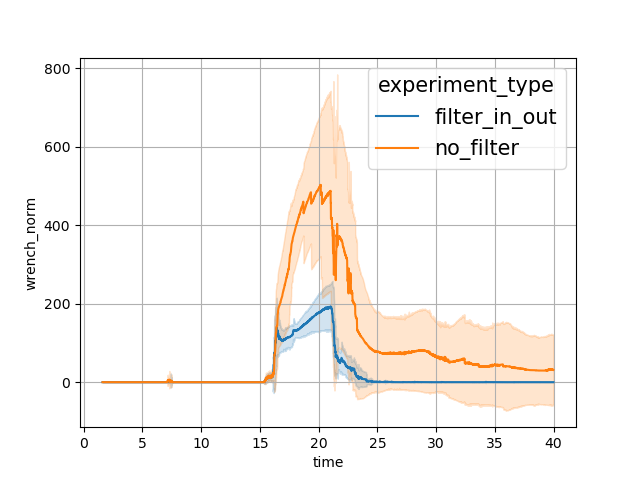

t_min=1.604999999999934 and t_max=39.98599999999751


In [42]:
%matplotlib notebook
fig, ax = plt.subplots()
# sns.barplot(x='x', y="average_wrench_norm", hue="experiment_type", data=data)
# ax.set_title("average_wrench norm distribution")
# ax.set_ylabel("||W|| [N]")
# display_save_button(fig)


# We need to align time across all the experiments 
from scipy.interpolate import interp1d

t_min = 0
t_max = np.inf
for t in data['sim_time']:
    if t[0] > t_min:
        t_min = t[0]
    if t[-1] < t_max:
        t_max = t[-1]
global_time = np.arange(t_min, t_max, step=0.01)
print(f"t_min={t_min} and t_max={t_max}")

i = 0
data_extended = {'time': [], 'wrench_norm': [], 'experiment_type': []}
for t, w, e in zip(data['sim_time'], data['wrench_norm'], data['experiment_type']):
    f = interp1d(t, w, kind='nearest')
    w = f(global_time)
    data_extended['time'].extend(global_time)
    data_extended['wrench_norm'].extend(w)
    data_extended['experiment_type'].extend([e] * len(global_time))
data_extended = pd.DataFrame.from_dict(data_extended)

sns.lineplot(x='time', y='wrench_norm', hue="experiment_type", data=data_extended, ci='sd')

### Wrench and energy tank

In [17]:
TOLL = 1 # deg to find the object release/fix indexes
if PLOT_EXPERIMENT:
    for exp in experiments_idx:
        fig, axs = plt.subplots(1, 2)
#         fig, ax = plt.subplots()
        
        time = np.array(data['sim_time'][exp])
        
        # find where the object is released
        object_positions = data['state'][exp][:, 24]
        object_fix = np.where(object_positions > np.pi * (30 - TOLL) / 180)[0][0]
        object_release = np.where(object_positions > np.pi * (30 + TOLL) / 180)[0][0]
        
        fix_time = time[object_fix]
        release_time = time[object_release]
        fix_window = np.logical_and(time>fix_time, time<release_time)
        
        # scalar_plot(data['sim_time'][exp], object_positions, prefix="object_position", axis=ax2)
        
        axs[0].plot(time, data['wrench_norm'][exp], lw=6, label="wrench norm")
        axs[0].fill_between(time, 0, 1, where=fix_window,
                facecolor='red', alpha=0.3, transform=axs[0].get_xaxis_transform(), label="fix")
        axs[0].set_title("Wrench norm")
        axs[0].set_ylabel("W [N]")
        axs[0].set_xlabel("t [s]")
        axs[0].legend()
        
        #axs[1].plot(data['sim_time'][exp], 0.5 * np.square(data['tank_state'][exp]), label="tank_energy")
        
        # Approximate the tank energy plot
        axs[1].plot(data['sim_time'][exp], 10 + np.cumsum(data['power_from_interaction'][exp])*0.010, 
                    label="tank energy", lw=6)
        axs[1].fill_between(time, 0, 1, where=fix_window,
                facecolor='red', alpha=0.3, transform=axs[1].get_xaxis_transform(), label="fix")
      
        MIN_ENERGY = 2
        axs[1].axhline(y=MIN_ENERGY, ls="--", lw=6)
        axs[1].set_title("Energy tank")
        axs[1].set_ylabel("E [J]")
        axs[1].set_xlabel("t [s]")
        axs[1].legend()
        
        FORMAT=True
        if FORMAT:
            for ax in axs:
                ax.title.set_size(50)
                ax.yaxis.label.set_size(50)
                ax.xaxis.label.set_size(50)
                ax.tick_params(axis='y', which='both', labelsize=40)
                ax.tick_params(axis='x', which='both', labelsize=30)
                ax.legend(fontsize= 48)
                fig.set_size_inches(42.5, 12.5)
        display_save_button(fig)

### Energy tank

In [18]:
if PLOT_EXPERIMENT:
    for exp in experiments_idx:
        fig, ax  = plt.subplots()
        ax.plot(data['sim_time'][exp], 0.5 * np.square(data['tank_state'][exp]), label="tank_energy")
        ax.plot(data['sim_time'][exp], 10 + np.cumsum(data['power_from_interaction'][exp])*0.015, label="power_from_interaction")
    
        MIN_ENERGY = 2
        ax.axhline(y=MIN_ENERGY, ls="--")
        ax.set_title("Energy tank")
        ax.legend()

#     matrix_plot(data['sim_time'][exp_idx], data['power_channels'][exp_idx], prefix="power_channels")

### Torque measurements

<IPython.core.display.Javascript object>


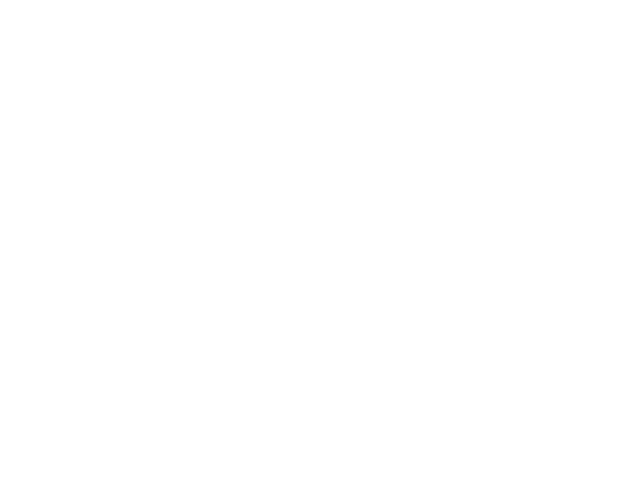

Button(description='Save Figure', style=ButtonStyle())

<IPython.core.display.Javascript object>


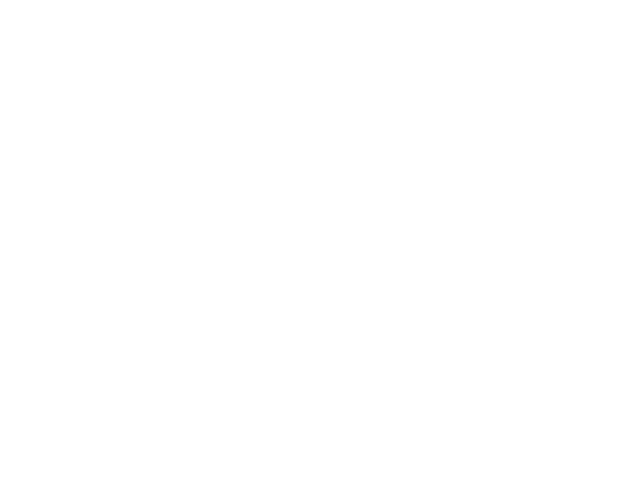

Button(description='Save Figure', style=ButtonStyle())

<IPython.core.display.Javascript object>


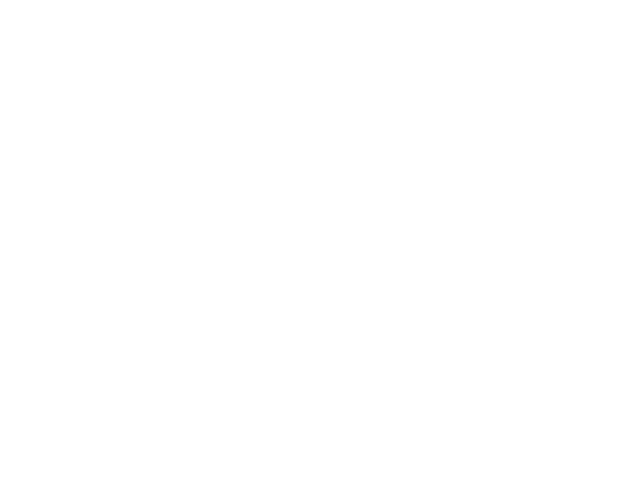

In [19]:
if PLOT_EXPERIMENT:
    ax = matrix_plot(data['sim_time'][exp_idx], data['external_torque'][exp_idx], prefix="external_torque")
    ax.set_title("External measured torque")
    ax.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)

    ax = matrix_plot(data['sim_time'][exp_idx], data['ground_truth_external_torque'][exp_idx], 
                      prefix="gt_external_torque")
    ax.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)

    # Compare estimated against ground truth
    uidx = 0
    fig, ax2 = plt.subplots()
    ax2.plot(data['sim_time'][exp_idx], data['external_torque'][exp_idx][:, uidx], label=f"est_{uidx}")
    ax2.plot(data['sim_time'][exp_idx], data['ground_truth_external_torque'][exp_idx][:, uidx], '--', 
             label=f"gt_{uidx}")
    ax2.legend()

### Stage cost

<IPython.core.display.Javascript object>


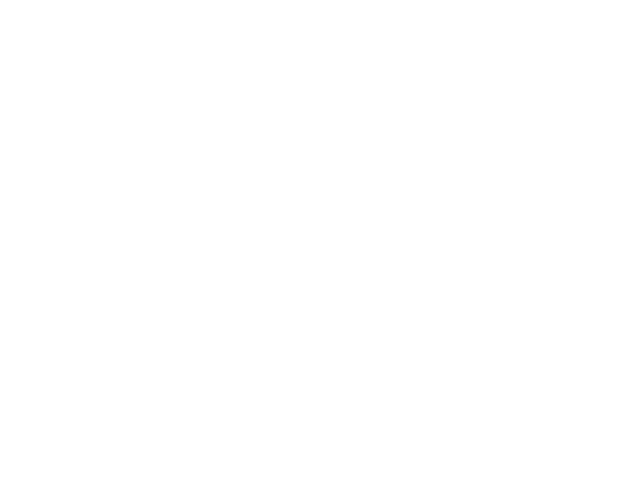

Button(description='Save Figure', style=ButtonStyle())

In [20]:
if PLOT_EXPERIMENT:
    ax = scalar_plot(data['sim_time'][exp_idx], data['stage_cost'][exp_idx], prefix="stage_cost")
    ax.set_title("stage_cost")

### Min cost

<IPython.core.display.Javascript object>


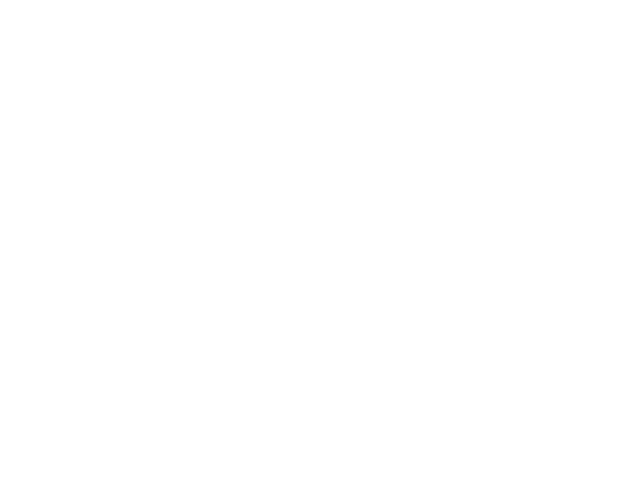

Button(description='Save Figure', style=ButtonStyle())

In [21]:
if PLOT_EXPERIMENT:
    ax = scalar_plot(data['sim_time'][exp_idx], data['min_cost'][exp_idx], prefix="min_cost")
    ax.set_title("Minimum rollout cost")

### Position desired

h_new_shelf_filter_in_out


<IPython.core.display.Javascript object>


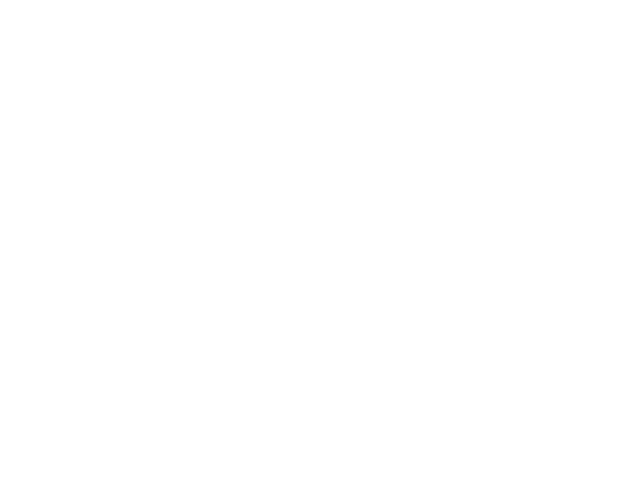

Button(description='Save Figure', style=ButtonStyle())

<IPython.core.display.Javascript object>


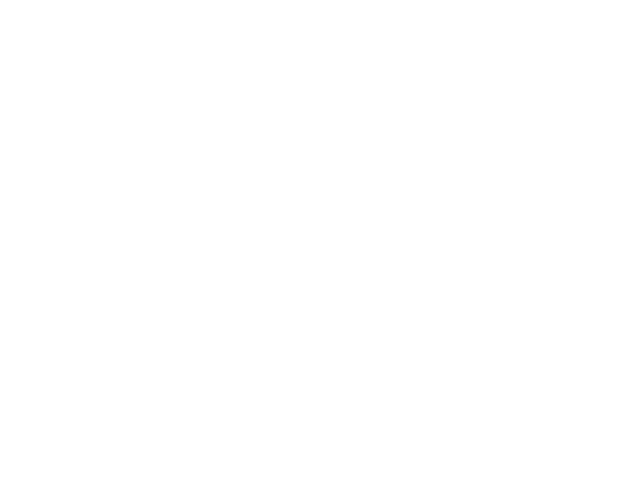

In [22]:
PLOT_EXPERIMENT = True
exp_idx = 0
print(data['experiment_name'][exp_idx])
if PLOT_EXPERIMENT:
    ax = matrix_plot(data['sim_time'][exp_idx], data['position_desired'][exp_idx], prefix="des")
    ax = matrix_plot(data['sim_time'][exp_idx], data['position_measured'][exp_idx], prefix="meas", 
                     linestyle="--", axis=ax)
    ax.legend(fontsize=10)

    # Compare only one channel
    uidx = 2
    fig2, ax2 = plt.subplots()
    ax2.plot(data['sim_time'][exp_idx], data['position_desired'][exp_idx][:, uidx], label=f"desired_{uidx}")
    ax2.plot(data['sim_time'][exp_idx], data['position_measured'][exp_idx][:, uidx], '--', label=f"measured_{uidx}")
    ax2.legend()

### Velocity measured

<IPython.core.display.Javascript object>


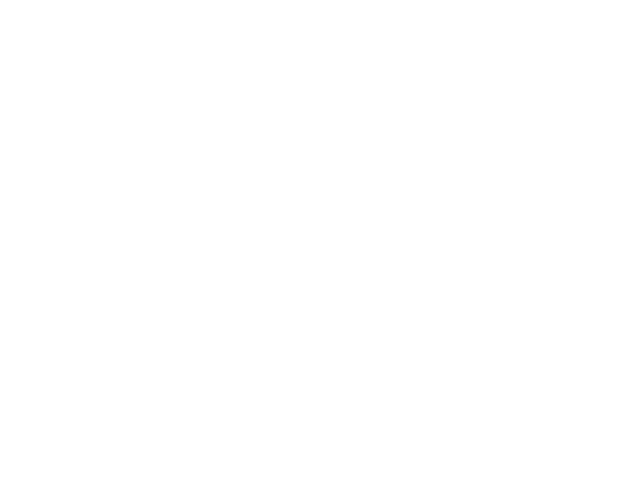

Button(description='Save Figure', style=ButtonStyle())

In [23]:
if PLOT_EXPERIMENT:
    ax = matrix_plot(data['sim_time'][exp_idx], data['velocity_measured'][exp_idx], prefix="velocity_measured")
    ax.set_title("Velocity measured")

### Velocity filtered

In [24]:
if PLOT_EXPERIMENT:
    ax = matrix_plot(data['sim_time'][exp_idx], data['velocity_filtered'][exp_idx], prefix="velocity_filtered")
    ax.set_title("Velocity filtered")

    # Compare filtered agains measured
    uidx = 3
    fig2, ax2 = plt.subplots()
    ax2.plot(data['sim_time'][exp_idx], data['velocity_measured'][exp_idx][:, uidx], label=f"measured_{uidx}")
    ax2.plot(data['sim_time'][exp_idx], data['velocity_filtered'][exp_idx][:, uidx], '--', label=f"filtered_{uidx}")
    ax2.legend()

KeyError: 'velocity_filtered'

### Velocity command

In [ ]:
if PLOT_EXPERIMENT:
    cmd_idx = 6
    ax = scalar_plot(data['sim_time'][exp_idx], data['velocity_command'][exp_idx][:,cmd_idx], 
                     prefix=f"before_filter_{cmd_idx}")
    ax = scalar_plot(data['sim_time'][exp_idx], data['velocity_mppi'][exp_idx][:,cmd_idx], 
                    prefix=f"after_filter_{cmd_idx}", axis=ax)
    ax.set_title("Velocity command")

### Torque command

In [ ]:
if PLOT_EXPERIMENT:
    ax = matrix_plot(data['sim_time'][exp_idx], data['torque_command'][exp_idx], prefix="torque_command")
    ax.set_title("Torque command")

### Joint limits violation

In [ ]:
if PLOT_EXPERIMENT:
    ax = matrix_plot(data['sim_time'][exp_idx], data['joint_limits_violation'][exp_idx], 
                 prefix="joint_limits_violation")
    ax.set_title("Joint limits violation")

### Cartesian limits violation

In [ ]:
if PLOT_EXPERIMENT:
    ax = matrix_plot(data['sim_time'][exp_idx], data['cartesian_limits_violation'][exp_idx], 
            prefix="cartesian_limits_violation")
    ax.set_title("Cartesian limits violation")

# Computation Performance Metrics

### Controller rate and delay steps
The solver keeps track of delay in optimizing the plan to adapt which portion of input is optimized in the future.
We then plot, what is the average deviation with respect to the nominal state. This should highlight the importance of the awareness of the required optimization time. 

In [ ]:
if PLOT_EXPERIMENT:
    exp_idx = 0
    print(data['experiment_name'][exp_idx])
    #ax = scalar_plot(data['sim_time'][exp_idx], data['delay_steps'][exp_idx], prefix="delay_steps")
    #ax.set_title("delay steps")
    ax = scalar_plot(data['sim_time'][exp_idx], 1.0/data['rate'][exp_idx], prefix="rate")
    
    fig, ax = plt.subplots()
    contact_state_idx = 26
    contact_mask = data['state'][exp_idx][:, contact_state_idx] > 0.0
    sim_step = data['simulation_step'][exp_idx][contact_mask]
    ax.plot(data['state'][exp_idx][:, contact_state_idx] , label="contact flag")
    ax.plot(data['simulation_step'][exp_idx] * 1000 , label="simulation_step")

    # We compute these metrics only when in contact as this is where the difference between meshes plays 
    # a role
    print(f"Max: {1.0/np.min(sim_step)/1000}, Min: {1.0/np.max(sim_step)/1000} KHz, Mean: {1.0/np.mean(sim_step)/1000} KHz, Std: {1.0/np.std(sim_step)/1000} KHz")
    print(f"Average opt time: {np.mean(data['opt_time'][exp_idx]) * 1000 } ms")
    print("\n\nSingle")
    print("Max: 39.91856612510479, Min: 0.08300425604322863 KHz, Avg: 2.940748217192103 KHz, Std: 1.7962439317248262 KHz")
    print("Two realistic")
    print("Max: 41.94454930581771, Min: 0.04337963820514144 KHz, Avg: 2.1332271154104614 KHz, Std: 1.2765470097347171 KHz")
    print("Convex hull")
    print("Max: 32.96739524610161, Min: 0.04788936484000188 KHz, Avg: 0.9756731241637593 KHz, Std: 0.7493113313931056 KHz")